<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/Bet%20Sizing/Bet_sizing_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BET SIZING

This notebook is based on the book *Advances in Financial Machine Learning* by Lopez De Prado. (Chapter 3 and Chapter 10)

In [0]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

In [0]:
# sklearn

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [10]:
# Big thanks to mlfinlab!

!pip install mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util, sampling

     |████████████████████████████████| 153kB 3.3MB/s 


# 1. Bet sizing (probability) - applying meta-labeling

We fit a
classifier, such as an SVC or RF, to determine the probability of misclassification, and
use that probability to derive the bet size.

### WHY do we use meta-labeling for sizing the bet?

Advantages
1. The ML algorithm that decides the bet sizes is independent of the primary model, allowing for the incorporation of features predictive of false positives (see below). 

2. The predicted probability can be directly translated into bet size.

### What is meta labeling?

Suppose that you have a model for setting the side of the bet (long or short). You just need to learn the size of that bet, which includes the possibility of no bet at all (zero size). This is a situation that practitioners face regularly. We often know whether we want to buy or sell a product, and the only remaining question is **how much money we should risk in such a bet**. We do not want the ML algorithm to learn the side, just
to tell us what is the **appropriate size**. We want to build a **secondary ML model** that learns how to use a primary exogenous model.

Binary classification problems present a trade-off between type-I errors (false positives) and type-II errors (false negatives). In general, increasing the true positive rate of a binary classifier will tend to increase its false positive rate. The receiver operating characteristic (ROC) curve of a binary classifier measures the cost of increasing the true positive rate, in terms of accepting higher false positive rates.

Meta-labeling is particularly helpful when you want to achieve higher F1-scores. First, we build a model that achieves high recall, even if the precision is not particularly high. Second, we correct for the low precision by applying meta-labeling to the positives predicted by the primary model.

Meta-labeling will increase your F1-score by filtering out the false positives, where the majority of positives have already been identified by the primary model. Stated differently, the role of the secondary ML algorithm is to determine whether a positive from the primary (exogenous) model is true or false. It is not its purpose to come up with a betting opportunity. Its purpose is to determine **whether we should act or pass
on the opportunity that has been presented.**



Advantages of meta-labeling

First, ML algorithms are often criticized as black boxes.
Meta-labeling allows you to build an ML system on top of a white box (like a fundamental model founded on economic theory). This ability to transform a fundamental model into an ML model should make meta-labeling particularly useful to “quantamental” firms. 

Second, the effects of overfitting are limited when you apply meta labeling,
because ML will not decide the side of your bet, only the size. 

Third, by decoupling the side prediction from the size prediction, meta-labeling enables sophisticated strategy structures. For instance, consider that the features driving a rally may differ from the features driving a sell-off. In that case, you may want to develop an
ML strategy exclusively for long positions, based on the buy recommendations of a primary model, and an ML strategy exclusively for short positions, based on the sell recommendations of an entirely different primary model. 

Fourth, achieving high accuracy on small bets and low accuracy on large bets will ruin you. As important as identifying good opportunities is to size them properly, so it makes sense to develop an ML algorithm solely focused on getting that critical decision (sizing) right. - Bet Sizing

Four steps


1. Use your forecasts from the primary model, and generate meta-labels. Remember, horizontal barriers do not need to be symmetric in this case.

2. Fit your model again on the same training set, but this time using the meta-labels you just generated.

3. Combine the “sides” from the first ML model with the “sizes” from the second ML model. I.e. if your primary model predicts a 3 and your secondary model says you have a high probability of the primary model being correct, is your final prediction a 3, else not 3.

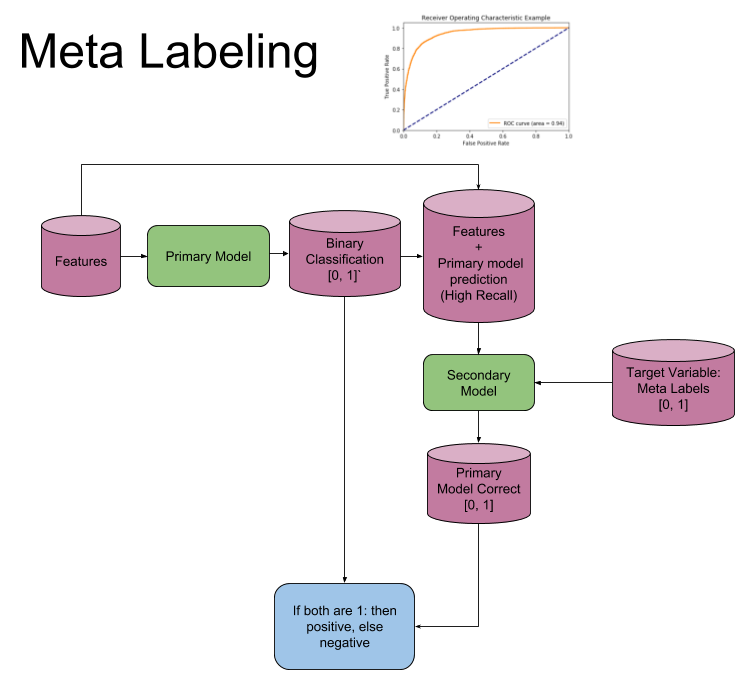

In [11]:
from IPython.core.display import Image
Image(filename='/content/drive/My Drive/Colab Notebooks/images/meta-labeling.png')

### Steps 


https://hudsonthames.org/does-meta-labeling-add-to-signal-efficacy-triple-barrier-method/

1. Compute long short signals for the strategy. For instance, in the mean-reverting strategy, generate a long signal when the close price is below the lower Bollinger band and create a sell signal if the close price is higher than the upper Bollinger band. We call this the “Primary model”.

2. Get time stamps of the events using CUSUM (or cumulative sum control chart) filter and point estimate of the volatility. See section 4.2.
Determine events when one of the three exit points (profit taking, stop-loss and vertical barrier) occur. Advances in Financial Machine Learning discusses this in Chapter 3. The result of this step is a trade decision – long or short, or 1 or -1.

3. Determine the bet size. The prior step tell us the direction of the trade. This step says if we should trade or not – a one or zero decision.
Tune the hyper-parameters (max_depth and n_estimators) of Random Forest using grid search and cross-validation. We keep the random state constant for reproducibility of the results.

4. Train a machine-learning algorithm (we use Random Forest for illustration) with new features like one to five day serial correlations, one to five-day returns, 50-day volatility, and 14-day RSI. We iterate over this step number of times until we see in-sample results that are acceptable. In other words, we only exit this step when we consider the model to be ready and there is no turning back.

5. Evaluate the performance of in sample and out-of-sample or this meta-model model.
Evaluate the performance of the “Primary model”
Compare the performance of the meta-model and the primary model

### Read in data - dollar bars

In [12]:
# make dollar bars from tick data
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=1_000_000)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [13]:
dollar_bars.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:46:35,62,50.79,51.07,50.710,51.07,19844,13264,62,1.010425e+06
2009-09-28 09:53:49,108,51.07,51.15,51.050,51.14,20324,16274,46,1.038593e+06
2009-09-28 09:55:26,143,51.14,51.15,51.129,51.14,19622,13098,35,1.003401e+06
2009-09-28 10:02:52,201,51.14,51.26,51.080,51.25,22319,17454,58,1.142880e+06
2009-09-28 10:10:21,254,51.25,51.29,51.190,51.29,21519,14254,53,1.103149e+06


In [0]:
close = dollar_bars.close

WHY do we use dollar bars?

See Chapter 2

### 1. Train a primary model (which decides 'sides') 

- Based on the simple moving average cross-over strategy.

In [0]:
fast_window = 20
slow_window = 50

df = pd.DataFrame()
df['fast_mavg'] = close.rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = close.rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df['side'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

df['side'] = df['side'].shift(1)

side = df['side']

In [16]:
side.value_counts()

 1.0    32190
-1.0    26367
Name: side, dtype: int64

### 2. Generate meta-labels (from a primary model)

In [0]:
# form a tripple-barrier
pt_sl = [1,2]

target = util.get_daily_vol(close,lookback=50)

h = target.mean()*0.5
t_events = filters.cusum_filter(close, h) # using symmetric cusum filter get t_events

vertical_barrier_times = labeling.add_vertical_barrier(t_events, close, num_days=1)

In [18]:
# events
min_ret = 0.005

events = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=3, 
                             vertical_barrier_times = vertical_barrier_times ,side_prediction = side)

# label (bin) - binary classification from the primary model

bin = labeling.get_bins(events, close)

2020-01-29 16:27:21.564076 100.0% apply_pt_sl_on_t1 done after 0.21 minutes. Remaining 0.0 minutes.


In [19]:
bin.describe()

,ret,trgt,bin,side
count,6404.000000,6410.000000,6410.000000,6404.000000
mean,-0.000117,0.009983,0.312012,-0.059963
std,0.013082,0.006454,0.463351,0.998279
min,-0.237752,0.005000,0.000000,-1.000000
25%,-0.007115,0.006446,0.000000,-1.000000
50%,0.001033,0.008225,0.000000,-1.000000
75%,0.007684,0.011075,1.000000,1.000000
max,0.373211,0.094337,1.000000,1.000000


In [0]:
bin.dropna(inplace=True)

In [21]:
bin.side.value_counts()

-1.0    3394
 1.0    3010
Name: side, dtype: int64

In [22]:
bin.bin.value_counts()

0    4404
1    2000
Name: bin, dtype: int64

### 3. Features and primary model predicition



Features - Kara et al. (2011)


- Simple 10-day moving average
- Weighted 10-day moving average
- Momentum
- Stochastic K%
- Stochastic D%
- RSI (Relative Strength Index) 100
- MACD (moving average convergence divergence)
- Larry William’s R% 
- A/D (Accumulation/Distribution) Oscillator
- CCI (Commodity Channel Index)

In [0]:
!pip install -q ta

https://github.com/bukosabino/ta

In [0]:
import ta

In [26]:
bars = dollar_bars.iloc[:,1:6]
bars.head()

,open,high,low,close,volume
date_time,,,,,
2009-09-28 09:46:35,50.79,51.07,50.710,51.07,19844
2009-09-28 09:53:49,51.07,51.15,51.050,51.14,20324
2009-09-28 09:55:26,51.14,51.15,51.129,51.14,19622
2009-09-28 10:02:52,51.14,51.26,51.080,51.25,22319
2009-09-28 10:10:21,51.25,51.29,51.190,51.29,21519


Volume
- Accumulation/Distribution Index (ADI)
-On-Balance Volume (OBV)
-Chaikin Money Flow (CMF)
-Force Index (FI)
-Ease of Movement (EoM, EMV)
-Volume-price Trend (VPT)
-Negative Volume Index (NVI)

Volatility
- Average True Range (ATR)
- Bollinger Bands (BB)
- Keltner Channel (KC)
- Donchian Channel (DC)

Trend
- Moving Average Convergence Divergence (MACD)
- Average Directional Movement Index (ADX)
- Vortex Indicator (VI)
- Trix (TRIX)
- Mass Index (MI)
- Commodity Channel Index (CCI)
- Detrended Price Oscillator (DPO)
- KST Oscillator (KST)
- Ichimoku Kinkō Hyō (Ichimoku)
- Parabolic Stop And Reverse (Parabolic SAR)

Momentum
- Money Flow Index (MFI)
- Relative Strength Index (RSI)
- True strength index (TSI)
- Ultimate Oscillator (UO)
- Stochastic Oscillator (SR)
- Williams %R (WR)
- Awesome Oscillator (AO)
- Kaufman's Adaptive Moving Average (KAMA)
- Rate of Change (ROC)

Others
- Daily Return (DR)
- Daily Log Return (DLR)
- Cumulative Return (CR)

In [0]:
ta_features = ta.add_all_ta_features(bars,'open','high','low','close','volume')

In [334]:
ta_features = ta_features.shift(1)
ta_features.head()

,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-09-28 09:46:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-28 09:53:49,50.79,51.07,50.710,51.07,19844.0,19844.000000,19844.0,1.000000,NaN,NaN,NaN,-8686.388581,1000.0,0.0,51.070000,51.070000,51.070000,0.000000,0.0,0.0,50.950000,50.950000,50.590000,0.0,0.0,51.07,51.07,1.0,1.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,39.762077,-437.753692,-437.753692,0.000000,50.890,50.890,90.806191,90.757522,4.0,4.0,0.0,51.070,NaN,NaN,0.0,0.0,100.0,NaN,NaN,NaN,100.000000,100.000000,-0.000000,0.0,NaN,NaN,-43.775369,NaN,0.000000
2009-09-28 09:55:26,51.07,51.15,51.050,51.14,20324.0,36103.200000,40168.0,0.898805,NaN,103.326117,103.326117,-8658.926806,1000.0,0.0,51.105000,51.175000,51.035000,0.140000,0.0,0.0,51.031667,51.031667,50.801667,0.0,0.0,51.07,51.14,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,66.666667,39.727077,-437.368365,-437.561028,0.192663,50.930,50.930,90.806191,90.757522,8.0,4.0,4.0,51.140,NaN,NaN,0.0,0.0,100.0,NaN,100.0,NaN,97.727273,98.863636,-2.272727,0.0,NaN,NaN,0.137067,0.136973,0.137067
2009-09-28 10:02:52,51.14,51.15,51.129,51.14,19622.0,37037.580952,59790.0,0.619461,NaN,4.227398,53.776757,27.857451,1000.0,0.0,51.116667,51.182663,51.050670,0.131993,0.0,0.0,51.067667,51.067667,50.907333,0.0,0.0,51.07,51.14,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,61.189802,39.715410,-437.239923,-437.453993,0.214070,50.930,50.930,90.806191,90.757522,8.0,4.0,4.0,51.070,NaN,51.07,0.0,1.0,100.0,NaN,100.0,NaN,97.727273,98.484848,-2.272727,0.0,NaN,NaN,0.000000,0.000000,0.137067
2009-09-28 10:10:21,51.14,51.26,51.080,51.25,22319.0,56876.692063,82109.0,0.692697,NaN,24.597876,44.050464,48.007235,1000.0,0.0,51.150000,51.278841,51.021159,0.257682,0.0,0.0,51.099917,51.099917,50.934667,0.0,0.0,51.07,51.25,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,86.047804,39.682077,-436.872945,-437.308731,0.435786,50.985,50.985,90.806191,90.757522,16.0,4.0,12.0,51.129,51.129,NaN,1.0,0.0,100.0,NaN,100.0,NaN,98.181818,97.878788,-1.818182,0.0,NaN,NaN,0.215096,0.214865,0.352457


In [335]:
#ta_features_2 = ta_features.dropna(axis=1,how='any',thresh=len(ta_features)-10)
#ta_features_2 = ta_features_2.dropna()
#ta_features_2 = ta_features_2.iloc[:,5:]
ta_features.columns


Index(['open', 'high', 'low', 'close', 'volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbm', 'volatility_bbh',
       'volatility_bbl', 'volatility_bbw', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dchi', 'volatility_dcli', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_ema_fast',
       'trend_ema_slow', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_visual_ichimoku_a',
       'trend_visual_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
   

In [0]:
ta_features_3 = ta_features.loc[:, ['volume_sma_em','volume_adi', 'volatility_atr', 'trend_macd',
                    'trend_ema_fast',
                    'trend_cci',
                    'momentum_rsi', 'momentum_stoch', 'momentum_wr', 'momentum_ao', 'momentum_kama']]

In [337]:
ta_features_3 = ta_features_3.dropna(axis=1,how='any',thresh=len(ta_features)-20)
ta_features_3 = ta_features_3.dropna()
ta_features_3

,volume_sma_em,volume_adi,volatility_atr,trend_ema_fast,trend_cci,momentum_rsi,momentum_stoch,momentum_wr,momentum_ao,momentum_kama
date_time,,,,,,,,,,
2009-09-28 11:51:43,22.017403,8.585340e+04,0.112274,51.266403,103.827976,80.693238,94.505028,-5.494972,0.108269,51.342000
2009-09-28 12:03:21,21.139081,1.011685e+05,0.106917,51.291572,120.355607,83.546586,99.173554,-0.826446,0.114567,51.358978
2009-09-28 12:33:18,19.699668,1.085860e+05,0.099625,51.312714,112.542746,83.295028,98.493151,-1.506849,0.117836,51.368380
2009-09-28 13:20:29,19.373130,1.058097e+05,0.096762,51.335374,121.756459,84.820849,91.111111,-8.888889,0.134563,51.380167
2009-09-28 13:44:27,11.819094,1.129197e+05,0.097046,51.357347,111.531243,85.649586,92.604651,-7.395349,0.148534,51.410104
...,...,...,...,...,...,...,...,...,...,...
2019-06-28 15:58:59,6.868165,1.273846e+07,0.123016,116.412902,150.055809,69.638073,95.454545,-4.545455,0.357253,116.422010
2019-06-28 15:59:02,-4.663667,1.272917e+07,0.121714,116.435532,110.363884,63.760434,72.727273,-27.272727,0.376792,116.424335
2019-06-28 15:59:45,-5.552428,1.272917e+07,0.111543,116.456219,88.025958,64.086867,75.000000,-25.000000,0.377347,116.429076


In [338]:
'''raw_data = pd.DataFrame(close)

log_ret = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)

# Volatility
raw_data['volatility_50'] = log_ret.rolling(window=50, min_periods=50, center=False).std()
raw_data['volatility_31'] = log_ret.rolling(window=31, min_periods=31, center=False).std()
raw_data['volatility_15'] = log_ret.rolling(window=15, min_periods=15, center=False).std()

# Serial Correlation
window_autocorr = 50

raw_data['autocorr_1'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)

# Remove look ahead bias
raw_data = raw_data.shift(1)'''

"raw_data = pd.DataFrame(close)\n\nlog_ret = np.log(raw_data['close']).diff()\n\n# Momentum\nraw_data['mom1'] = raw_data['close'].pct_change(periods=1)\nraw_data['mom2'] = raw_data['close'].pct_change(periods=2)\nraw_data['mom3'] = raw_data['close'].pct_change(periods=3)\n\n# Volatility\nraw_data['volatility_50'] = log_ret.rolling(window=50, min_periods=50, center=False).std()\nraw_data['volatility_31'] = log_ret.rolling(window=31, min_periods=31, center=False).std()\nraw_data['volatility_15'] = log_ret.rolling(window=15, min_periods=15, center=False).std()\n\n# Serial Correlation\nwindow_autocorr = 50\n\nraw_data['autocorr_1'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)\nraw_data['autocorr_2'] = log_ret.rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)\nraw_data['autocorr_3'] = log_ret.rolling(window=window_autocorr, min_periods=

In [339]:
'''raw_X = raw_data.iloc[:,1:]
raw_X.dropna(inplace=True)
raw_X.head()'''

'raw_X = raw_data.iloc[:,1:]\nraw_X.dropna(inplace=True)\nraw_X.head()'

PCA

In [340]:
# Feature decomposition PCA
'''
n=5
pca = PCA(n)
pca.fit(raw_X)
pcaX = pca.transform(raw_X)

X = pd.DataFrame(index=raw_X.index)
for i in range(n):
  a = pd.Series(data=pcaX[:,i],index=raw_X.index,name=i)
  X = X.join(a)

X['side'] = side

X.head()'''

"\nn=5\npca = PCA(n)\npca.fit(raw_X)\npcaX = pca.transform(raw_X)\n\nX = pd.DataFrame(index=raw_X.index)\nfor i in range(n):\n  a = pd.Series(data=pcaX[:,i],index=raw_X.index,name=i)\n  X = X.join(a)\n\nX['side'] = side\n\nX.head()"

In [0]:
#PCA
n=5
pca = PCA(n)
pca.fit(ta_features_3)
pcaX = pca.transform(ta_features_3)

X = pd.DataFrame(index=ta_features_3.index)
for i in range(n):
  a = pd.Series(data=pcaX[:,i],index=ta_features_3.index,name=i)
  X = X.join(a)
'''
#No PCA
X = ta_features_3.copy()
'''
X = X.pct_change()

In [342]:
X['side'] = side

X.head()

,0,1,2,3,4,side
date_time,,,,,,
2009-09-28 11:51:43,NaN,NaN,NaN,NaN,NaN,NaN
2009-09-28 12:03:21,-0.001739,-0.008488,0.166567,0.029110,0.024306,NaN
2009-09-28 12:33:18,-0.000844,-0.016735,-0.060622,0.078737,0.007844,NaN
2009-09-28 13:20:29,0.000316,-0.002693,0.043961,-0.516352,0.079297,NaN
2009-09-28 13:44:27,-0.000809,-0.084058,-0.070272,0.468317,0.040598,NaN


In [0]:
X.dropna(inplace=True)

# stationary

In [344]:
len(X)

58557

### 4. Fit a second ML model

In [0]:
tmp_data = X.copy()
tmp_data = tmp_data.join(bin.bin)
tmp_data.dropna(inplace=True)

X = tmp_data.iloc[:,:-1]
y = tmp_data[['bin']]

In [346]:
X

,0,1,2,3,4,side
date_time,,,,,,
2009-09-30 15:05:38,-5.747037e-05,-0.064639,0.306241,0.071582,-0.149135,-1.0
2009-10-01 09:30:07,1.870053e-04,1.348901,-0.338122,-1.107802,-0.221326,-1.0
2009-10-01 09:52:26,8.676311e-04,-0.663908,0.670150,-0.018655,0.328264,-1.0
2009-10-01 10:00:33,-7.153833e-12,0.212891,-0.058428,-0.345114,-0.045121,-1.0
2009-10-01 11:16:04,-1.198180e-03,-0.521759,-0.203266,-0.377886,0.823353,-1.0
...,...,...,...,...,...,...
2019-06-12 11:59:18,2.246395e-03,0.353808,0.519601,-4.243012,0.056936,-1.0
2019-06-13 09:36:29,1.371066e-03,0.409313,-0.069991,0.481628,-0.014298,-1.0
2019-06-18 09:50:22,2.245278e-03,1.030479,4.093757,-0.625468,0.001149,-1.0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

In [348]:
avgU = sampling.get_av_uniqueness_from_triple_barrier(events, close, 3).mean()
max_samples = avgU[0]
max_samples

2020-01-29 18:37:17.715963 100.0% num_concurrent_events done after 0.07 minutes. Remaining 0.0 minutes.
2020-01-29 18:37:20.549472 100.0% _get_average_uniqueness done after 0.05 minutes. Remaining 0.0 minutes.


0.28313174769037236

In [0]:
#clf0 = RandomForestClassifier(n_estimators=1,criterion='entropy',bootstrap = False, class_weight='balanced_subsample')
#clf1 = BaggingClassifier(base_estimator=clf0, max_samples=max_samples, max_features=1, n_estimators=1000)
#clf1.fit(X_train, y_train.values.ravel())

#this is the method in the book

In [0]:
#y_pred = clf1.predict(X_test)
#y_pred_prob = clf1.predict_proba(X_test)[:, 1] # 1로 예상할 확률

In [351]:
parameters = {'max_depth':[2, 3, 5, 7],
              'n_estimators':[100, 512, 1000]}
#hyper-parameter tuning

rf = RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample')
clf = GridSearchCV(rf, parameters, cv=3, n_jobs=3)
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob

In [352]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1000, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

Train metrics

In [0]:
y_pred_prob_0 = clf.predict_proba(X_train)[:, 1]
y_pred_0 = clf.predict(X_train)

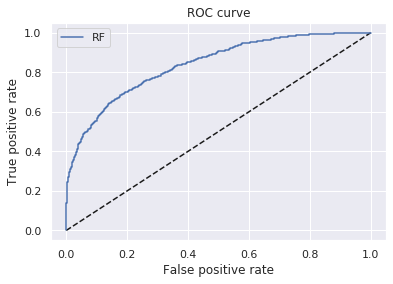

In [354]:
fpr_rf_0, tpr_rf_0, _ = roc_curve(y_train, y_pred_prob_0)

%matplotlib inline

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf_0, tpr_rf_0, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84      2788
         1.0       0.58      0.69      0.63      1054

    accuracy                           0.78      3842
   macro avg       0.73      0.75      0.74      3842
weighted avg       0.79      0.78      0.78      3842

Accuracy =  0.7787610619469026

Confusion Matrix


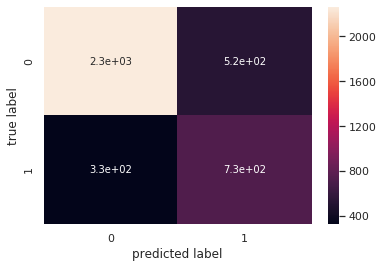

In [355]:
print(classification_report(y_train, y_pred_0))

print("Accuracy = ", accuracy_score(y_train, y_pred_0))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [0]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

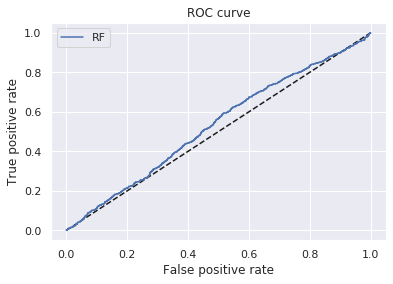

In [357]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob)

%matplotlib inline

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

         0.0       0.64      0.67      0.66      1616
         1.0       0.39      0.35      0.37       946

    accuracy                           0.56      2562
   macro avg       0.51      0.51      0.51      2562
weighted avg       0.55      0.56      0.55      2562

Accuracy =  0.5550351288056206

Confusion Matrix


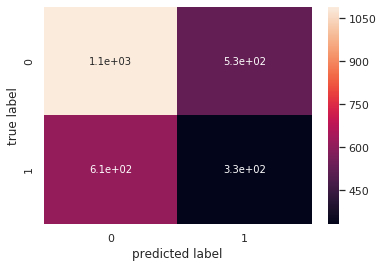

In [358]:
print(classification_report(y_test, y_pred))

print("Accuracy = ", accuracy_score(y_test, y_pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

### Bet Sizing

When num_classes = 2,

$$z = \frac{p[x=1]−\frac{1}{2}}{\sqrt{p[x=1](1−p[x=1])}} $$

$$m = 2Z [z] − 1$$

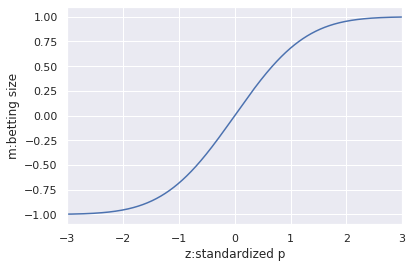

In [359]:
import scipy.stats as ss
p = np.linspace(0.001,1,1000,endpoint=False)
z = (p-0.5)/(np.sqrt(p*(1-p)))
Z_z = ss.norm.cdf(z)
m = (2 * Z_z -1) # np.sign(x)=1 always? increasing function
plt.plot(z,m)
plt.xlim(-3,3)
plt.xlabel('z:standardized p');
plt.ylabel('m:betting size');

In [0]:
from mlfinlab import bet_sizing as bs

In [0]:
p = y_pred_prob # from RF (secondary model)

In [362]:
X_test

,0,1,2,3,4,side
date_time,,,,,,
2015-07-09 09:56:21,0.003374,0.041781,-0.237891,-0.461607,0.081412,-1.0
2015-07-09 12:00:31,0.002427,-0.011868,-0.487838,0.038163,-0.000775,-1.0
2015-07-09 15:59:28,0.017381,0.422409,0.120428,4.355802,-0.009465,1.0
2015-07-10 09:35:27,-0.012006,-1.547495,-0.096356,-0.275462,-0.018205,1.0
2015-07-10 11:48:00,-0.005229,-0.003830,-0.004176,6.866708,0.021414,1.0
...,...,...,...,...,...,...
2019-06-12 11:59:18,0.002246,0.353808,0.519601,-4.243012,0.056936,-1.0
2019-06-13 09:36:29,0.001371,0.409313,-0.069991,0.481628,-0.014298,-1.0
2019-06-18 09:50:22,0.002245,1.030479,4.093757,-0.625468,0.001149,-1.0


In [363]:
new_data = y_test.copy()
new_data['p'] = p
new_data['pred'] = y_pred
new_data

,bin,p,pred
date_time,,,
2015-07-09 09:56:21,0.0,0.497232,0.0
2015-07-09 12:00:31,0.0,0.516414,1.0
2015-07-09 15:59:28,1.0,0.626563,1.0
2015-07-10 09:35:27,1.0,0.462918,0.0
2015-07-10 11:48:00,1.0,0.406625,0.0
...,...,...,...
2019-06-12 11:59:18,0.0,0.478692,0.0
2019-06-13 09:36:29,0.0,0.527678,1.0
2019-06-18 09:50:22,0.0,0.520287,1.0


In [0]:
# test에 맞추자
new_events = events.loc[new_data.index]
bs_df = pd.concat([new_events, new_data],axis=1)

In [365]:
bs_df

,t1,trgt,side,pt,sl,bin,p,pred
date_time,,,,,,,,
2015-07-09 09:56:21,2015-07-10 09:56:51,0.008702,-1.0,1,2,0.0,0.497232,0.0
2015-07-09 12:00:31,2015-07-10 12:27:37,0.007981,-1.0,1,2,0.0,0.516414,1.0
2015-07-09 15:59:28,2015-07-10 09:35:27,0.006833,1.0,1,2,1.0,0.626563,1.0
2015-07-10 09:35:27,2015-07-13 09:30:23,0.006412,1.0,1,2,1.0,0.462918,0.0
2015-07-10 11:48:00,2015-07-13 09:30:23,0.005870,1.0,1,2,1.0,0.406625,0.0
...,...,...,...,...,...,...,...,...
2019-06-12 11:59:18,2019-06-13 12:16:14,0.005909,-1.0,1,2,0.0,0.478692,0.0
2019-06-13 09:36:29,2019-06-14 09:48:52,0.005255,-1.0,1,2,0.0,0.527678,1.0
2019-06-18 09:50:22,2019-06-19 09:57:29,0.005684,-1.0,1,2,0.0,0.520287,1.0


In [0]:
m_prob = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3)

In [367]:
m_prob

date_time
2015-07-09 09:56:21   -0.004417
2015-07-09 12:00:31    0.026203
2015-07-09 15:59:28    0.206407
2015-07-10 09:35:27   -0.059283
2015-07-10 11:48:00   -0.150764
                         ...   
2019-06-12 11:59:18   -0.034023
2019-06-13 09:36:29    0.044213
2019-06-18 09:50:22    0.032390
2019-06-18 12:22:51   -0.167303
2019-06-19 14:01:58   -0.063298
Name: signal, Length: 2562, dtype: float64

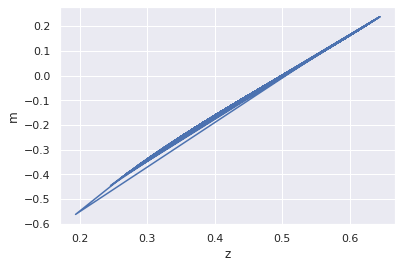

In [368]:
plt.plot(p, m_prob)
plt.xlabel('z');
plt.ylabel('m');

average

In [369]:

m_prob_avg = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, average_active=True)
m_prob_avg = m_prob_avg.loc[bs_df.index]

2020-01-29 18:38:54.952523 100.0% mp_avg_active_signals done after 0.16 minutes. Remaining 0.0 minutes.


In [370]:
m_prob_avg

date_time
2015-07-09 09:56:21   -0.004417
2015-07-09 12:00:31    0.010893
2015-07-09 15:59:28    0.076064
2015-07-10 09:35:27   -0.012499
2015-07-10 11:48:00   -0.061282
                         ...   
2019-06-12 11:59:18   -0.061241
2019-06-13 09:36:29    0.005095
2019-06-18 09:50:22    0.032390
2019-06-18 12:22:51   -0.067456
2019-06-19 14:01:58   -0.063298
Length: 2562, dtype: float64

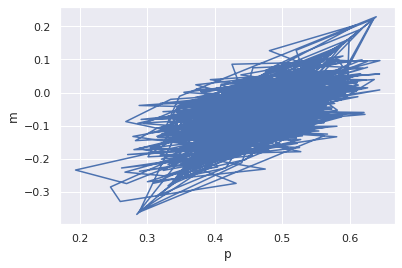

In [371]:
plt.plot(p, m_prob_avg)
plt.xlabel('p');
plt.ylabel('m');

discrete

In [372]:
m_prob_discrete = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, average_active=True, step_size=0.01)
m_prob_discrete = m_prob_discrete.loc[bs_df.index]

2020-01-29 18:39:05.562866 100.0% mp_avg_active_signals done after 0.16 minutes. Remaining 0.0 minutes.


In [373]:
m_prob_discrete

date_time
2015-07-09 09:56:21   -0.00
2015-07-09 12:00:31    0.01
2015-07-09 15:59:28    0.08
2015-07-10 09:35:27   -0.01
2015-07-10 11:48:00   -0.06
                       ... 
2019-06-12 11:59:18   -0.06
2019-06-13 09:36:29    0.01
2019-06-18 09:50:22    0.03
2019-06-18 12:22:51   -0.07
2019-06-19 14:01:58   -0.06
Length: 2562, dtype: float64

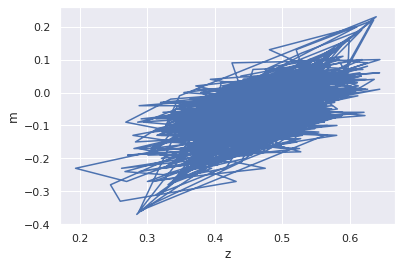

In [374]:
plt.plot(p, m_prob_discrete)
plt.xlabel('z');
plt.ylabel('m');

# Bet Sizing (reserve)

$c_t = c_{t,l} - c_{t,s} $ 

where $c_{t,l}$ is the number of concurrent long bets at
time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$

$$m_t = \begin{cases}
  \frac{F[c_t]-F[0]}{1-F[0]} & \text{if}\ c_t \ge 0 \\
  \frac{F[c_t]-F[0]}{F[0]} & \text{if}\ c_t < 0
\end{cases}$$

where $F[x]$ is CDF of the fitted mixture of two Gaussians for a value x.

EF3M Algorithm



https://github.com/hudson-and-thames/research/blob/master/Chapter10/ef3m_testing.ipynb

In [375]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=bs_df['t1'], sides=bs_df.side, return_parameters=True, fit_runs=50)

|#########################| Completed 50 of 50 fitting rounds.

In [376]:
m_reserve[0]

,t1,side,active_long,active_short,c_t,bet_size
date_time,,,,,,
2015-07-09 09:56:21,2015-07-10 09:56:51,-1.0,0,1,-1,-0.151881
2015-07-09 12:00:31,2015-07-10 12:27:37,-1.0,0,2,-2,-0.305209
2015-07-09 15:59:28,2015-07-10 09:35:27,1.0,1,2,-1,-0.151881
2015-07-10 09:35:27,2015-07-13 09:30:23,1.0,1,2,-1,-0.151881
2015-07-10 11:48:00,2015-07-13 09:30:23,1.0,2,1,1,0.213848
...,...,...,...,...,...,...
2019-06-12 11:59:18,2019-06-13 12:16:14,-1.0,3,1,2,0.405916
2019-06-13 09:36:29,2019-06-14 09:48:52,-1.0,0,2,-2,-0.305209
2019-06-18 09:50:22,2019-06-19 09:57:29,-1.0,0,1,-1,-0.151881


In [0]:
BetSizeReserve = m_reserve[0].bet_size

In [378]:
m_reserve[1]
#parameter for two Gaussian mixture

{'mu_1': -1.44884,
 'mu_2': 3.70815,
 'p_1': 0.92822,
 'sigma_1': 4.10739,
 'sigma_2': 2.85453}

# Bet sizing (budget)

$$ m_t = c_{t,l}\frac{1}{max_i[c_{i,l}]} − c_{t,s}\frac{1}{max_i[c_{i,s}]} $$

In [379]:
m_budget = bs.bet_sizing.bet_size_budget(bs_df.t1, bs_df.side)
m_budget

,t1,side,active_long,active_short,bet_size
date_time,,,,,
2015-07-09 09:56:21,2015-07-10 09:56:51,-1.0,0,1,-0.035714
2015-07-09 12:00:31,2015-07-10 12:27:37,-1.0,0,2,-0.071429
2015-07-09 15:59:28,2015-07-10 09:35:27,1.0,1,2,0.000000
2015-07-10 09:35:27,2015-07-13 09:30:23,1.0,1,2,0.000000
2015-07-10 11:48:00,2015-07-13 09:30:23,1.0,2,1,0.107143
...,...,...,...,...,...
2019-06-12 11:59:18,2019-06-13 12:16:14,-1.0,3,1,0.178571
2019-06-13 09:36:29,2019-06-14 09:48:52,-1.0,0,2,-0.071429
2019-06-18 09:50:22,2019-06-19 09:57:29,-1.0,0,1,-0.035714


In [0]:
BetSizeBudget = m_budget.bet_size

# Overview

In [381]:
bet_size_0 = pd.DataFrame({'BetSizeProb':m_prob,'BetSizeProbAvg':m_prob_avg,'BetSizeProbDiscrete':m_prob_discrete})
bet_size_1 = bet_size_0.join(BetSizeReserve)
bet_size = bet_size_1.join(BetSizeBudget,rsuffix='2')
bet_size = bet_size.rename(columns={'bet_size':'BetSizeReserve', 'bet_size2':'BetSizeBudget'})
bet_size

,BetSizeProb,BetSizeProbAvg,BetSizeProbDiscrete,BetSizeReserve,BetSizeBudget
date_time,,,,,
2015-07-09 09:56:21,-0.004417,-0.004417,-0.00,-0.151881,-0.035714
2015-07-09 12:00:31,0.026203,0.010893,0.01,-0.305209,-0.071429
2015-07-09 15:59:28,0.206407,0.076064,0.08,-0.151881,0.000000
2015-07-10 09:35:27,-0.059283,-0.012499,-0.01,-0.151881,0.000000
2015-07-10 11:48:00,-0.150764,-0.061282,-0.06,0.213848,0.107143
...,...,...,...,...,...
2019-06-12 11:59:18,-0.034023,-0.061241,-0.06,0.405916,0.178571
2019-06-13 09:36:29,0.044213,0.005095,0.01,-0.305209,-0.071429
2019-06-18 09:50:22,0.032390,0.032390,0.03,-0.151881,-0.035714


In [0]:
bet_size.dropna(inplace=True)

Plot

Text(0.5, 1.0, 'Bet Size 100 points')

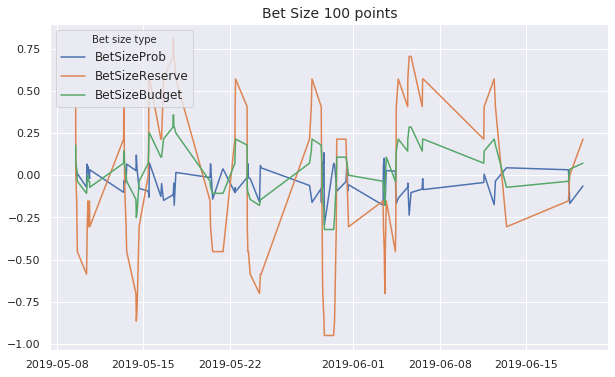

In [383]:
fig, ax = plt.subplots(figsize=(10,6))
bet_size_3 = bet_size.drop(['BetSizeProbAvg','BetSizeProbDiscrete'],axis=1)
ax.plot(bet_size_3[-100:])

ax.legend(labels=bet_size_3.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Prob 100 points')

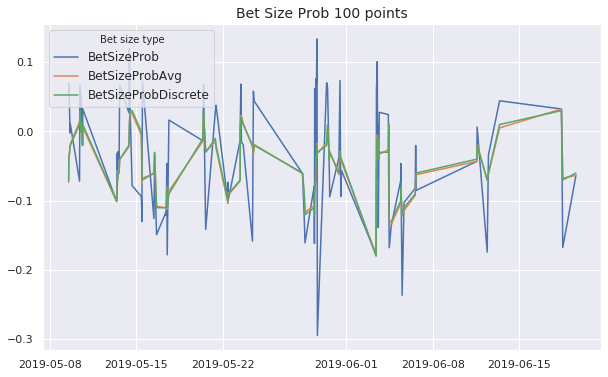

In [384]:
fig, ax = plt.subplots(figsize=(10,6))
bet_size_4 = bet_size.iloc[:,:3]
ax.plot(bet_size_4[-100:])

ax.legend(labels=bet_size_4.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size Prob 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution')

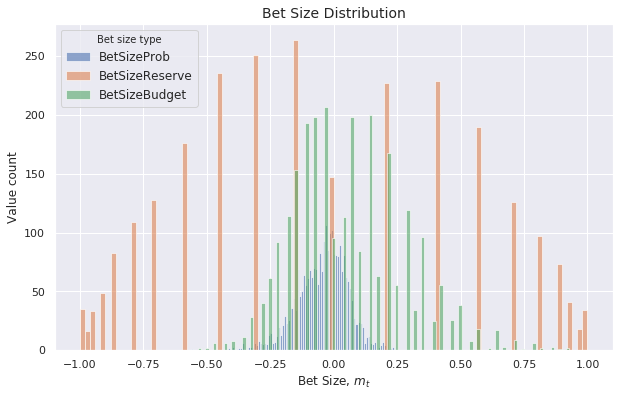

In [385]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['BetSizeProb','BetSizeReserve', 'BetSizeBudget']:
    ax.hist(bet_size_3[c],  label=c, alpha=0.6, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution')

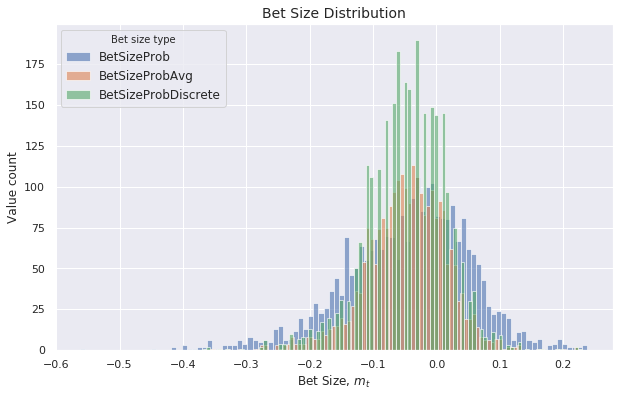

In [386]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['BetSizeProb','BetSizeProbAvg', 'BetSizeProbDiscrete']:
    ax.hist(bet_size_4[c],  label=c, alpha=0.6, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution", fontsize=14)

# REFERENCE

Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley, 2018

https://github.com/hudson-and-thames/research

Marcos Lopez de Prado and Matthew D. Foreman. “A mixture ofGaussians approach to mathematical portfolio oversight: the EF3M algorithm”. In: Quantitative Finance14.5 (2014), pp. 913–930.